# Mammographic masses data

## 1. Download and import dataset

In [12]:
# Import libraries
import pandas as pd
import plotly.express as px

# Import the provided dataset
data_file = 'mammographic_masses_data.csv'
df = pd.read_csv(data_file)
df.head(10)

,BA,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
8,5.0,57.0,1.0,5.0,3.0,1
9,5.0,60.0,NaN,5.0,1.0,1


## 2. Get dataset on screen

In [13]:
# Initial look at the dataset
df.describe()

,BA,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.300313,55.487448,2.721505,2.796276,2.910734,0.463059
std,0.683469,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,6.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [14]:
df.mode()

,BA,Age,Shape,Margin,Density,Severity
0,4.0,59.0,4.0,1.0,3.0,0


In [15]:
# Flitering the margins where severity is 1
df.loc[df['Severity'] == 1]['Margin']

0      5.0
1      1.0
2      5.0
4      5.0
8      5.0
      ... 
951    5.0
952    4.0
955    4.0
957    5.0
959    5.0
Name: Margin, Length: 445, dtype: float64

In [16]:
# Three basic visualizations that capture the essence of the dataset

# Basic scatter plot to see all relationships
fig1 = px.scatter_matrix(
    data_frame=df,
    template='plotly_dark',
    title='Relationships in the dataset',
)

fig1.show()

# Bar chart with relationship between the margin and density and how this translates to severity
bar_data = df.groupby(['Margin', 'Density'], as_index=False)[['Severity']].mean()

fig2 = px.bar(
        data_frame=df,
        x='Margin',
        y='Density',
        color='Severity',
        opacity=0.9,
        orientation='v',
        barmode='overlay',
        title='Severity based on margin and density',
        template='plotly_dark'
)

fig2.show()

# Boxplot to see the relationship between severity and age
fig3 = px.box(
    data_frame=df,
    x='Severity',
    y="Age",
    title='Cancer severity per age',
    template='plotly_dark',
)

fig3.show()

## 3. Preprocessing

In [17]:
import plotly.figure_factory as ff

# Clean the data from missing values
# Filling the NaN values with the median
cleaned_df = df.copy()
cleaned_df.fillna(df.median().iloc[0], inplace=True)

# Dropping the NaN values
dropped_na_df = df.dropna()

# Defining the plotting data
x1 = dropped_na_df['Age'].values
x2 = cleaned_df['Age'].values

hist_data = [x1, x2]
group_labels = ['Dropped Na', 'Median']
colors = ['#333F44', '#37AA9C']

# Seeing the difference between dropping nan values of filling with the median
fig10 = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)
fig10.show()

In [18]:
# Normalization algorithm
min_value = cleaned_df['Age'].min()
max_value = cleaned_df['Age'].max()

cleaned_df['Age'] = cleaned_df['Age'].apply(lambda x: (x-min_value)/(max_value-min_value))

cleaned_df.head()

,BA,Age,Shape,Margin,Density,Severity
0,5.0,0.684783,3.0,5.0,3.0,1
1,4.0,0.423913,1.0,1.0,4.0,1
2,5.0,0.586957,4.0,5.0,3.0,1
3,4.0,0.260870,1.0,1.0,3.0,0
4,5.0,0.760870,1.0,5.0,4.0,1


In [19]:
# Difference between data and normalized data
fig6 = px.box(cleaned_df, x='Density', y="Age")
fig6.show()

fig7 = px.box(df, x='Density', y="Age")
fig7.show()

## 4. Feature engineering

In [20]:
# Automatic feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Remove BA because it is non-predictive
predictive_df = cleaned_df.drop(columns=['BA', 'Severity'])

# Seperating features and label
X = predictive_df.values
y = cleaned_df['Severity'].values

# Applying the SelectKBest algorithm
X_new = SelectKBest(chi2, k=2)
X_new.fit_transform(X, y)

# Making a new dataframe from the new values
columns = X_new.get_support(indices=True)
features_df_new = predictive_df.iloc[:,columns]

features_df_new.head()

,Shape,Margin
0,3.0,5.0
1,1.0,1.0
2,4.0,5.0
3,1.0,1.0
4,1.0,5.0


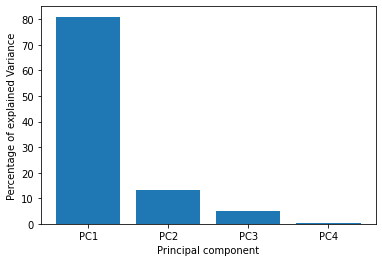

Margin     0.806110
Shape      0.590772
Age        0.034124
Density    0.003383
dtype: float64


In [35]:
# PCA dimensionality reduction
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Defining the model
pca = PCA()

# Seperating features and label
X = predictive_df.values
Y = cleaned_df.loc[cleaned_df['Severity'] == 1].drop(columns=['BA', 'Severity']).values
Z = cleaned_df.loc[cleaned_df['Severity'] == 0].drop(columns=['BA', 'Severity']).values
feature_names = predictive_df.keys()

# Fitting and transforming the data to the model
pca.fit(X)
pca_data_1 = pca.transform(Y)
pca_data_2 = pca.transform(Z)

# Calculate the percentage of variation that each principal component accounts for
per_principal_component = np.round(pca.explained_variance_ratio_*100, decimals=1)

# Creating the labels of each principal component
labels = ['PC' + str(x) for x in range(1, len(per_principal_component) + 1)]

# Plotting the principal components
plt.bar(x=range(1, len(per_principal_component) + 1), height=per_principal_component, tick_label=labels)
plt.ylabel("Percentage of explained Variance")
plt.xlabel('Principal component')
plt.show()

# Almost all of the variance is along PC1, so a 2D graph using PC1 and PC2 should do the job

# Importance of features based on loading scores
loading_scores = pd.Series(pca.components_[0], index=feature_names)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
print(sorted_loading_scores)

# Margin and shape are the top two loading scores, so these cause the largest variation in the dataframe

# Showing the pca graph
pca_data = pd.concat( [pd.DataFrame(pca_data_1), pd.DataFrame(pca_data_2)], keys=['Malignant', 'Benign']).reset_index(level=0)

fig7a = px.scatter(pca_data, x=0, y=1, color="level_0", title="PCA")
fig7a.show()

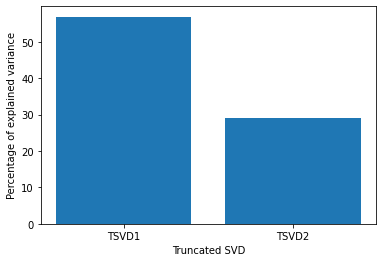

Margin     0.603369
Shape      0.565993
Density    0.551854
Age        0.105143
dtype: float64


In [36]:
# Truncated SVD
from sklearn.decomposition import TruncatedSVD

# Defining the model
tsvd = TruncatedSVD(n_components=2)

# Fitting and transforming the data to the model
tsvd.fit(X)
tsvd_data = tsvd.transform(X)

# Calculate the percentage of variation that each truncated svd accounts for
per_tsvd = np.round(tsvd.explained_variance_ratio_*100, decimals=1)

# Creating the labels of each principal component
labels = ['TSVD' + str(x) for x in range(1, len(per_tsvd) + 1)]

# Plotting the principal components
plt.bar(x=range(1, len(per_tsvd) + 1), height=per_tsvd, tick_label=labels)
plt.ylabel("Percentage of explained variance")
plt.xlabel('Truncated SVD')
plt.show()

# Importance of features based on loading scores
loading_scores = pd.Series(tsvd.components_[0], index=feature_names)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
print(sorted_loading_scores)

# Margin and shape are the top two loading scores, so these cause the largest variation in the dataframe

# Data needed for the plot
tsvd_data_1 = tsvd.transform(Y)
tsvd_data_2 = tsvd.transform(Z)
tsvd_data = pd.concat([pd.DataFrame(tsvd_data_1), pd.DataFrame(tsvd_data_2)], keys=['Malignant', 'Benign']).reset_index(level=0)

# Plotting the data
fig8 = px.scatter(tsvd_data, x=0, y=1, color="level_0", title="Truncated SVD")
fig8.show()